In [2]:
import ROOT as rt
import csv
import re
import sys
import collections

from collections import OrderedDict
import uproot

import scipy
import numpy as np
import numpy as np
from scipy.stats import norm
import math
import sys
import os
sys.path.append(os.getcwd().replace('scripts', 'lib'))

import tdrstyle
style = tdrstyle.setTDRStyle()

print(sys.version)

3.9.12 (main, Jun  7 2022, 16:09:12) 
[GCC 11.2.0]


# Load ntuples

In [3]:
path = '/eos/uscms/store/user/cmsdas/2024/long_exercises/MDS/data/'
data_file = path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

print(data_file)
root_dir = uproot.open(data_file) 
tree = root_dir['MuonSystem']
NEvents = root_dir['NEvents'].values()[0] #get first bin of histogram
print(NEvents)



/eos/uscms/store/user/cmsdas/2024/long_exercises/MDS/data/Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root
22763250.0


# OOT Control Region Selection

In [11]:
oot_flag = 1
# if 0 then do inverted cut-based ID region
T = tree
        
########### SELECTION: CLUSTERS ############


sel_rechitcluster = np.abs(T['cscRechitClusterEta'].array()) < 2.0

me1112_veto = 0
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberPlus11'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberPlus12'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberMinus11'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterNRechitChamberMinus12'].array() <= me1112_veto)

sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitCluster_match_MB1Seg_0p4'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitCluster_match_RE12_0p4'].array() <= me1112_veto)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitCluster_match_RB1_0p4'].array() <= me1112_veto)

sel_rechitcluster = np.logical_and( sel_rechitcluster, T['cscRechitClusterJetVetoPt'].array() < 10)
sel_rechitcluster = np.logical_and( sel_rechitcluster, T['cscRechitClusterMuonVetoPt'].array() < 20)
sel_rechitcluster = np.logical_and(sel_rechitcluster, T['cscRechitClusterTimeSpread'].array() <= 20)


if oot_flag:
    sel_rechitcluster = np.logical_and(sel_rechitcluster,  T['cscRechitClusterTime'].array() < -12.5)

else:
    sel_rechitcluster = np.logical_and(sel_rechitcluster, np.logical_and(T['cscRechitClusterTime'].array() < 12.5, \
                                                                         T['cscRechitClusterTime'].array() > -5.0))



########### SELECTION: JETS ############

sel_jet = np.logical_and(T['jetPt'].array() > 30, np.abs(T['jetEta'].array()) < 2.4 )
sel_jet = np.logical_and(sel_jet, T['jetTightPassId'].array())

########### SELECTION: EVENTS ############
# select only triggered events
sel_ev = T['METTrigger'].array()


sel_ev  = np.logical_and(sel_ev,np.sum(sel_rechitcluster,axis=1) >= 1)
sel_ev = np.logical_and(sel_ev ,T['met'].array() > 200)
sel_ev = np.logical_and(sel_ev , np.sum(sel_jet,axis=1)>=1)
sel_ev = np.logical_and(sel_ev,T['metFilters'].array())


##### cut based ID ####
cscRechitClusterNStation = T['cscRechitClusterNStation'].array()[sel_rechitcluster][sel_ev][:,0]
cscRechitClusterEta = T['cscRechitClusterEta'].array()[sel_rechitcluster][sel_ev][:,0]
cscRechitClusterPhi = T['cscRechitClusterPhi'].array()[sel_rechitcluster][sel_ev][:,0]
cscRechitClusterAvgStation = T['cscRechitClusterAvgStation'].array()[sel_rechitcluster][sel_ev][:,0]
cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation)==2, np.abs(cscRechitClusterEta) < 1.6)
cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation)==3, np.abs(cscRechitClusterEta) < 1.6)
cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation)==4, np.abs(cscRechitClusterEta) < 1.8)
cond1 = np.logical_and(cscRechitClusterNStation==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation)==1, cond2), np.logical_or(cond3, cond4)))
cond2 = np.logical_and(cscRechitClusterNStation > 1, np.abs(cscRechitClusterEta) < 1.9)
bdt_sel = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
if oot_flag == 0: bdt_sel = np.logical_not(bdt_sel)    

#### Save variables needed for ABCD ####                                   
                                   
deltaPhi = T['cscRechitClusterMet_dPhi'].array()[sel_rechitcluster][sel_ev][:,0][bdt_sel]
Nhits = T['cscRechitClusterSize'].array()[sel_rechitcluster][sel_ev][:,0][bdt_sel]

### print correlation between the two variables ####
print(scipy.stats.pearsonr(Nhits, deltaPhi))


(0.03331639426149141, 0.42401883668905105)


# plot distribution of dphi and Nrechits

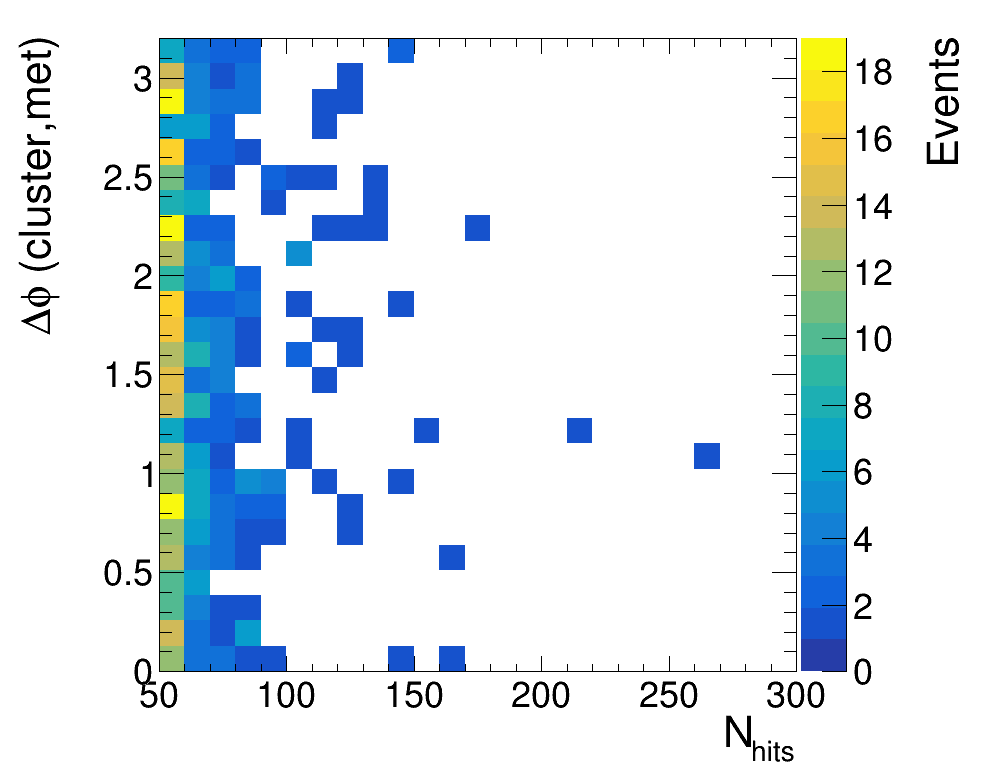

In [12]:
# Plotting ncsc
c = rt.TCanvas('c','c', 1000, 800)

h = rt.TH2D()
h = rt.TH2D('', '', 25,50,300,25,0,3.2)
h.SetXTitle('N_{hits}')
h.SetYTitle('#Delta#phi (cluster,met)')
h.SetZTitle('Events')
for i in range(len(Nhits)):
    h.Fill(Nhits[i],np.abs(deltaPhi)[i])

h.Draw('colz')
c.SetRightMargin(0.2)
c.Draw()

# c.SaveAs()



# ABCD validation (Scan $N_{hits}$ or $\Delta\phi\mathrm{(cluster, MET)}$)

In [23]:
n_ev = 5000

scan_nhits = 0

if scan_nhits:
    dphi_scan = [0.75]
    nhits_scan = np.arange(60,200,10)
else:
    dphi_scan = np.arange(9,22,1)/20
    nhits_scan = [130]

    
print('cut \t A \t B \t C \t D \t prediction \t uncertainty')
print()
for N_RECHIT_CUT in nhits_scan:
    for DPHI_CUT in dphi_scan:
        var = np.abs(deltaPhi)
        a = np.sum(np.logical_and(Nhits>=N_RECHIT_CUT, np.abs(deltaPhi)<DPHI_CUT))
        b = np.sum(np.logical_and(Nhits>=N_RECHIT_CUT, np.abs(deltaPhi)>=DPHI_CUT))
        c = np.sum(np.logical_and(Nhits<N_RECHIT_CUT, np.abs(deltaPhi)>=DPHI_CUT))
        d = np.sum(np.logical_and(Nhits<N_RECHIT_CUT, np.abs(deltaPhi)<DPHI_CUT))


        pred = b*d/c
        unc_pred = (1./c + 1./b + 1./d)**0.5*(pred)
        
        if scan_nhits: print(N_RECHIT_CUT, '\t',a,'\t',b,'\t',c,'\t',d,'\t', round(pred, 2), '\t',round( unc_pred, 2))
        else: print(DPHI_CUT, '\t',a,'\t',b,'\t',c,'\t',d,'\t', round(pred, 2), '\t', round( unc_pred, 2))


cut 	 A 	 B 	 C 	 D 	 prediction 	 uncertainty

0.45 	 2 	 12 	 495 	 69 	 1.67 	 0.53
0.5 	 2 	 12 	 490 	 74 	 1.81 	 0.57
0.55 	 2 	 12 	 481 	 83 	 2.07 	 0.65
0.6 	 3 	 11 	 471 	 93 	 2.17 	 0.7
0.65 	 3 	 11 	 465 	 99 	 2.34 	 0.75
0.7 	 3 	 11 	 450 	 114 	 2.79 	 0.89
0.75 	 3 	 11 	 443 	 121 	 3.0 	 0.96
0.8 	 3 	 11 	 433 	 131 	 3.33 	 1.06
0.85 	 3 	 11 	 422 	 142 	 3.7 	 1.17
0.9 	 3 	 11 	 407 	 157 	 4.24 	 1.34
0.95 	 4 	 10 	 398 	 166 	 4.17 	 1.37
1.0 	 4 	 10 	 382 	 182 	 4.76 	 1.57
1.05 	 4 	 10 	 374 	 190 	 5.08 	 1.67
